# practical_exercise_10 , Methods 3, 2021, autumn semester
### LAURA W. PAABY 
### 1/12 - 2O21

# Exercises and objectives
### 1) Use principal component analysis to improve the classification of subjective experience
### 2) Use logistic regression with cross-validation to find the optimal number of principal components
REMEMBER: In your report, make sure to include code that can reproduce the answers requested in the
exercises below (MAKE A KNITTED VERSION)
REMEMBER: This is Assignment 4 and will be part of your final portfolio



# EXERCISE 1 - Use principal component analysis to improve the
### classification of subjective experience
We will use the same files as we did in Assignment 3 The files megmag_data.npy and pas_vector.npy
can be downloaded here (http://laumollerandersen.org/data_methods_3/megmag_data.npy) and here
(http://laumollerandersen.org/data_methods_3/pas_vector.npy)

The function equalize_targets is supplied - this time, we will only work with an equalized data set. One motivation for this is that we have a well-defined chance level that we can compare against. Furthermore, wewill look at a single time point to decrease the dimensionality of the problem

In [169]:
###LOADING LIBRARIES
## importing libraries
import statistics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.model_selection import train_test_split
import scipy as sp
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import os


## 1) Create a covariance matrix, find the eigenvectors and the eigenvalues
#### i. Load megmag_data.npy and call it data using np.load. You can use join, which can be imported from os.path, to create paths from different string segments

In [167]:
# IMPORTING DATA
import requests
import io

# THE MEG DATA 
response = requests.get('http://laumollerandersen.org/data_methods_3/megmag_data.npy')
response.raise_for_status()
data = np.load(io.BytesIO(response.content))

#numbers of repitions of visual stimuli: 682
#numbers of sensors (spots in the cap that record magnetic fields): 102
#numbers of time samples: 251



# THE PAS VECTOR 
response = requests.get('http://laumollerandersen.org/data_methods_3/pas_vector.npy')
response.raise_for_status()
y = np.load(io.BytesIO(response.content))

#### ii. Equalize the number of targets in y and data using equalize_targets

In [ ]:
### DEFINING THE EQUIALIZER FUNCTION
def equalize_targets(data, y):
    np.random.seed(7)
    targets = np.unique(y)
    counts = list()
    indices = list()
    for target in targets:
        counts.append(np.sum(y == target))
        indices.append(np.where(y == target)[0])
    min_count = np.min(counts)
    first_choice = np.random.choice(indices[0], size=min_count, replace=False)
    second_choice = np.random.choice(indices[1], size=min_count, replace=False)
    third_choice = np.random.choice(indices[2], size=min_count, replace=False)
    fourth_choice = np.random.choice(indices[3], size=min_count, replace=False)
    new_indices = np.concatenate((first_choice, second_choice,
    third_choice, fourth_choice))
    new_y = y[new_indices]
    new_data = data[new_indices, :, :]
    return new_data, new_y

In [ ]:
## EQUALIZING THE DATA AND Y:
data_equal, y_equal = equalize_targets(data, y)

iii. Construct times=np.arange(-200, 804, 4) and find the index corresponding to 248 ms - then
reduce the dimensionality of data from three to two dimensions by only choosing the time index
corresponding to 248 ms (248 ms was where we found the maximal average response in Assignment
3)

In [ ]:
#making the time array
times=np.arange(-200, 804, 4)

In [ ]:
## finding the time
time248 = np.argwhere(times == 248)
print("the time index corresponding to 248 ms:",time248)

the time index corresponding to 248 ms: [[112]]


In [155]:
## squeezing the data to two dim with the time point in the data:
data_time = data_equal[:,:,time248].squeeze()
print("the data is now two dimensional:", data_time.shape)


the data is now two dimensional: (396, 102)
(396, 102)


iv. Scale the data using StandardScaler

In [ ]:
# standardizing 
sc = StandardScaler()
data_time_std = sc.fit_transform(data_time)

v. Calculate the sample covariance matrix for the sensors (you can use np.cov) and plot it (either using plt.imshow or sns.heatmap (import seaborn as sns))

(102, 102)


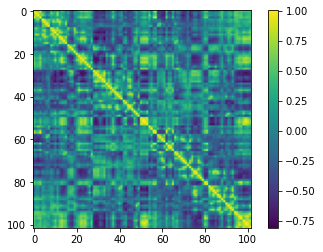

In [ ]:
cov_mat = np.cov(data_time_std.T)
plt.imshow(cov_mat)
plt.colorbar()

#the shape of features 
print(cov_mat.shape)

vi. What does the off-diagonal activation imply about the independence of the signals measured by
the 102 sensors?

*There appears to be a rather high covariance in the off-diagonal activation, looking at the colors. We see how many matches the colours on the scale around -0.75 and 1, indicating high covariance. The independece signals are therefore quite low, we'd argued*

vii. Run np.linalg.matrix_rank on the covariance matrix - what integer value do you get? (we’ll use this later)

In [ ]:
np_lin_matrix = np.linalg.matrix_rank(cov_mat)
print("the rank of the cov matrix:", np_lin_matrix)

the rank of the cov matrix: 97


viii. Find the eigenvalues and eigenvectors of the covariance matrix using np.linalg.eig - note that some of the numbers returned are complex numbers, consisting of a real and an imaginary part (they have a j next to them). We are going to ignore this by only looking at the real parts of the eigenvectors and -values. Use np.real to retrieve only the real parts

In [96]:
### finding eigen values and vectors 
eigen_values_mat, eigen_vectors_mat = np.linalg.eig(cov_mat)
print(eigen_values_mat, eigen_vectors_mat)

eigen_values_mat = np.real(eigen_values_mat)
eigen_vectors_mat = np.real(eigen_vectors_mat)

[ 2.86956421e+01  1.61532317e+01  1.19667828e+01  7.11946468e+00
  6.53758473e+00  3.56503758e+00  3.26728576e+00  2.74694300e+00
  2.58301935e+00  2.05934337e+00  1.76840286e+00  1.32700594e+00
  1.10080407e+00  1.04399299e+00  9.43037791e-01  8.43761487e-01
  7.56054528e-01  6.50829775e-01  6.06503267e-01  5.36007750e-01
  4.94678836e-01  4.00053880e-01  3.55520231e-01  3.29622537e-01
  3.09444655e-01  2.91850233e-01  2.65190752e-01  2.56099076e-01
  2.46024142e-01  2.35190093e-01  2.11523920e-01  2.15787340e-01
  2.02570026e-01  1.78607257e-01  1.83107840e-01  1.63718456e-01
  1.47542517e-01  1.43183916e-01  1.42175684e-01  1.35217523e-01
  1.30115449e-01  1.24802958e-01  1.22744036e-01  1.13727476e-01
  1.10608291e-01  1.03376043e-01  1.00246339e-01  9.66121945e-02
  9.22382747e-02  8.91661528e-02  8.80352165e-02  8.38123252e-02
  7.95106934e-02  7.56708457e-02  7.50049795e-02  7.17532589e-02
  7.29421553e-02  6.84257809e-02  6.52993774e-02  6.40611140e-02
  1.05260202e-02  5.98903

### 2) Create the weighting matrix W and the projected data, Z
i. We need to sort the eigenvectors and eigenvalues according to the absolute values of the eigenvalues (use np.abs on the eigenvalues).

In [153]:
abs_eigen_val = abs(eigen_values_mat)

ii. Then, we will find the correct ordering of the indices and create an array, e.g. sorted_indices that contains these indices. We want to sort the values from highest to lowest. For that, use np.argsort, which will find the indices that correspond to sorting the values from lowest to highest. 
Subsequently, use np.flip, which will reverse the order of the indices.

In [98]:
sorted_indices = np.flip(np.argsort(abs_eigen_val))
print(sorted_indices)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  31  30  32  34  33  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  56  55  57  58  59  61  64  66  71  72  73  74  76  77  78  82  93
  91  94  87  86  95  90  84  85  92  88  83  96  89  81  80  79  75  70
  69  68  67  65  63  62  60 101  97 100  99  98]


iii. Finally, create arrays of sorted eigenvalues and eigenvectors using the sorted_indices array just created. For the eigenvalues, it should like this eigenvalues = eigenvalues[sorted_indices] and for the eigenvectors: eigenvectors = eigenvectors[:, sorted_indices]

In [112]:
eigen_val_sorted = abs_eigen_val[sorted_indices]
eigen_vec_sorted = eigen_vectors_mat[:,sorted_indices]

iv. Plot the log, np.log, of the eigenvalues, plt.plot(np.log(eigenvalues), 'o') - are there some values that stand out from the rest? In fact, 5 (noise) dimensions have already been projected out of the data - how does that relate to the matrix rank (Exercise 1.1.vii)

Text(0, 0.5, 'log scale')

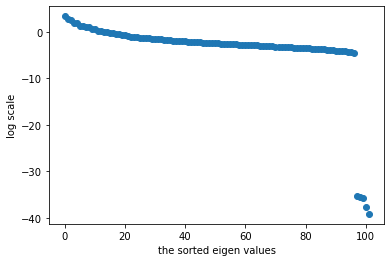

In [113]:
log_eigen = np.log(eigen_val_sorted)
plt.plot((log_eigen), 'o')
plt.xlabel("the sorted eigen values")
plt.ylabel("log scale")

there appears to be some noise around 100 ... write more cool stuff later:) 

the relation to the matrix rank????? the matrix rank was 97 just reminder :D

v. Create the weighting matrix, W (it is the sorted eigenvectors)

In [118]:
W = eigen_vec_sorted

 vi. Create the projected data, `Z`, $Z = XW$ - (you can check you did everything right by checking whether the $X$ you get from $X = ZW^T$ is equal to your original $X$, `np.isclose` may be of help)

In [119]:
X = data_time_std #saving the data in matrix X

#creating the projected data z:
Z = X @ W 

In [120]:
## checking if its equal to the original:
check_X = Z @ W.T
np.isclose(check_X, X)


array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

vii. Create a new covariance matrix of the principal components (n=102) - plot it! What has happened off-diagonal and why?

In [121]:
print(W.shape)

(102, 102)


(102, 102)


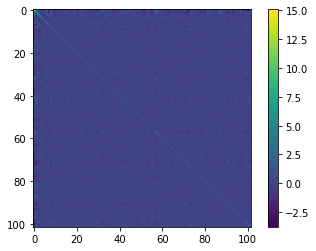

In [ ]:
cov_mat_pc = np.cov(Z.T)
plt.imshow(cov_mat_pc)
plt.colorbar()

#the shape of features 
print(cov_mat_pc.shape)

*we can now see how the off diagonal is totaly independet, meaning we have no covariance of the principal components - WUHU*

# EXERCISE 2 - Use logistic regression with cross-validation to find the optimal number of principal components
### 1) We are going to run logistic regression with in-sample validation

i. First, run standard logistic regression (no regularization) based on Zn×k and y (the target vector).
Fit (.fit) 102 models based on: k = [1, 2, ..., 101, 102] and n = 102. For each fit get the classification accuracy, (.score), when applied to Zn×k and y. This is an in-sample validation.
Use the solver newton-cg if the default solver doesn’t converge

In [135]:
k_score = []
for i in range(101):
    log_r = LogisticRegression(penalty= 'none', solver= "newton-cg")
    log_r.fit(Z[:,0:i+1], y_equal)
    score = log_r.score(Z[:,0:i+1], y_equal)
    k_score.append(score)


In [158]:
k_score = np.array(k_score)



print("the classification accuracy scores:", k_score)
print(k_score.shape)


the classification accuracy scores: [0.27525253 0.32070707 0.33333333 0.3510101  0.34090909 0.36363636
 0.37121212 0.36616162 0.37878788 0.37878788 0.38131313 0.39141414
 0.38383838 0.41161616 0.42424242 0.43939394 0.42929293 0.43939394
 0.43434343 0.4469697  0.45707071 0.46717172 0.44949495 0.45959596
 0.46464646 0.47979798 0.48484848 0.47979798 0.47979798 0.49242424
 0.49747475 0.52020202 0.51767677 0.52020202 0.50505051 0.51767677
 0.52777778 0.51515152 0.52777778 0.53030303 0.53787879 0.53030303
 0.54040404 0.51515152 0.52525253 0.51767677 0.51767677 0.51010101
 0.50757576 0.52525253 0.52525253 0.53282828 0.52272727 0.5479798
 0.55050505 0.54292929 0.53535354 0.53535354 0.53787879 0.52777778
 0.53787879 0.54040404 0.55808081 0.57070707 0.56818182 0.55555556
 0.55555556 0.55555556 0.58585859 0.58838384 0.59343434 0.58585859
 0.6010101  0.59343434 0.59848485 0.62373737 0.60606061 0.60606061
 0.62121212 0.61616162 0.62373737 0.62626263 0.61868687 0.61868687
 0.61363636 0.61111111 0.62

 ii. Make a plot with the number of principal components on the _x_-axis and classification accuracy on the _y_-axis - what is the general trend and why is this so?

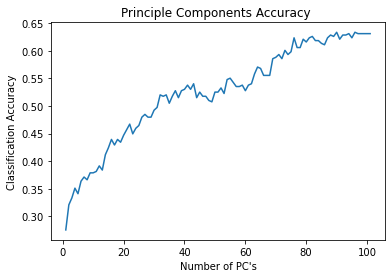

In [159]:
## remember the eigenvectors/principle components is saved in W:
#plotting
pc_list = np.arange(1, 102, 1)


plt.plot(pc_list, k_score)
plt.xlabel("Number of PC's")
plt.ylabel("Classification Accuracy")
plt.title("Principle Components Accuracy ")
plt.show()


*The trend appears to be that the accucary of the classification increases with the value of the principle components.* 

iii. In terms of classification accuracy, what is the effect of adding the five last components? Why do you think this is so?

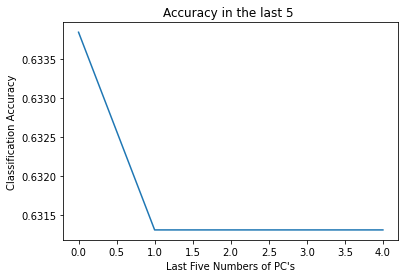

In [160]:
plt.plot(k_score[-6:-1])
plt.xlabel("Last Five Numbers of PC's")
plt.ylabel("Classification Accuracy")
plt.title("Accuracy in the last 5 ")
plt.show()
    

*We see how the accuracy decreases over the last five principal components, which makes sense since these PC's not contains much more than noise, and therefore don't contain information useful to classify.*

## 2) Now, we are going to use cross-validation - we are using `cross_val_score` and `StratifiedKFold` from `sklearn.model_selection`
    
i. Define the variable: `cv = StratifiedKFold()` and run `cross_val_score` (remember to set the `cv` argument to your created `cv` variable). Use the same `estimator` in `cross_val_score` as in Exercise 2.1.i. Find the mean score over the 5 folds (the default of `StratifiedKFold`) for each $k$, $k = [1, 2, ..., 101, 102]$  

In [164]:
from sklearn.model_selection import cross_val_score, StratifiedKFold 

In [180]:
#getting the cross val scores 
cv_score = []
cv = StratifiedKFold()
for i in range(101):
  logR = LogisticRegression(penalty='none', solver = 'newton-cg', random_state = 1) # no regularization
  logR.fit(Z[:,0:i+1],y_equal)
  scores = cross_val_score(logR,Z[:,0:i+1],y_equal, cv = 5 )
  mean_cv_score = np.mean(scores)
  cv_score.append(mean_cv_score)
  
cv_score_array = np.array(cv_score)


In [181]:
cv_score_array

array([0.23474684, 0.29522152, 0.3003481 , 0.32297468, 0.29018987,
       0.30550633, 0.30797468, 0.31056962, 0.32313291, 0.3281962 ,
       0.32316456, 0.33332278, 0.33335443, 0.36110759, 0.35094937,
       0.36882911, 0.34863924, 0.33348101, 0.3410443 , 0.35113924,
       0.35873418, 0.3485443 , 0.33341772, 0.36113924, 0.35623418,
       0.35367089, 0.35613924, 0.34598101, 0.33841772, 0.35607595,
       0.34848101, 0.34594937, 0.34598101, 0.3510443 , 0.34601266,
       0.33591772, 0.34098101, 0.32832278, 0.3181962 , 0.31563291,
       0.30050633, 0.29294304, 0.2853481 , 0.29047468, 0.27781646,
       0.28025316, 0.27522152, 0.27265823, 0.27018987, 0.28025316,
       0.27522152, 0.2878481 , 0.29028481, 0.28268987, 0.29287975,
       0.30297468, 0.28268987, 0.27512658, 0.28268987, 0.27265823,
       0.29037975, 0.27775316, 0.28775316, 0.2878481 , 0.29037975,
       0.29287975, 0.28528481, 0.28272152, 0.29287975, 0.30287975,
       0.31294304, 0.2953481 , 0.29787975, 0.28528481, 0.27518

ii. Make a plot with the number of principal components on the _x_-axis and classification accuracy on the _y_-axis - how is this plot different from the one in Exercise 2.1.ii?

Text(0, 0.5, 'Classification Accuracy')

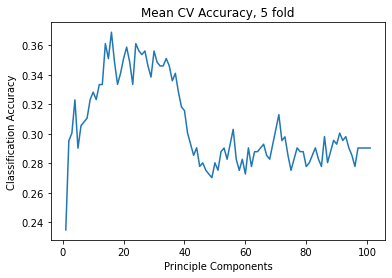

In [186]:
plt.plot(pc_list, cv_score_array)
plt.title("Mean CV Accuracy, 5 fold")
plt.xlabel("Principle Components")
plt.ylabel("Classification Accuracy")


In [ ]:
def equalize_targets_binary(data, y):
    np.random.seed(7)
    targets = np.unique(y) ## find the number of targets
    if len(targets) > 2:
        raise NameError ("can't have more than two targets") #may only be binary
    counts = list()
    indices = list()
    for target in targets:
        counts.append(np.sum(y == target)) ## find the number of each target
        indices.append(np.where(y == target)[0]) ## find their indices
    min_count = np.min(counts)
    # randomly choose trials
    first_choice = np.random.choice(indices[0], size=min_count, replace=False)
    second_choice = np.random.choice(indices[1], size=min_count,replace=False)
    # create the new data sets
    new_indices = np.concatenate((first_choice, second_choice))
    new_y = y[new_indices]

    new_data = data[new_indices, :, :]
    return new_data, new_y


#creating the new x and y
X_1_2_equal_new_o, y_1_2_equal_new = equalize_targets_binary(data_1_2, y_1_2)

#to be able to standardice, we must reshape it to be 2 dim
X_1_2_equal_new = X_1_2_equal_new_o.reshape(198,-1)


# standardizing 
sc = StandardScaler()
X_1_2_equal_std = sc.fit_transform(X_1_2_equal_new)



*how is this different???? at the small numbers of components it seem to be better to classify*

iii. What is the number of principal components, $k_{max\_accuracy}$, that results in the greatest classification accuracy when cross-validated?  

In [229]:

max_score_pc = np.unravel_index(np.argmax(cv_score_array), cv_score_array.shape)
print("the number of principle component with the highest classification accuracy score is:", pc_list[max_score_pc], "where the value is:", np.max(cv_score_array)*100, "%")

the number of principle component with the highest classification accuracy score is: 16 where the value is: 36.88291139240506 %


iv. How many percentage points is the classification accuracy increased with relative to the to the full-dimensional, $d$, dataset 

In [191]:
## to work with the full data, we should prepare it. It is already equalized:
print(data_equal.shape)

(396, 102, 251)


In [194]:
#this should then be reshaped, to be worked with:
data_equal_reshape = data_equal.reshape(396, -1)
print(data_equal_reshape.shape)

(396, 25602)


In [228]:


logR_d = LogisticRegression(penalty='none', solver = 'newton-cg', random_state = 1) # no regularization
logR_d.fit(data_equal_reshape[:,max_score_pc],y_equal)
scores_d = cross_val_score(logR_d, data_equal_reshape[:,max_score_pc],y_equal, cv = 5 )
mean_cv_score_d = np.mean(scores_d)

print("the accuracy score of the principle component with the highest previously (number 16), has in the full data the accuracy score:", mean_cv_score_d*100, "%")

the accuracy score of the principle component with the highest previously (number 16), has in the full data the accuracy score: 24.240506329113927 %


In [226]:
#the difference between these two in percent:
difference_percent = ((np.max(cv_score_array)-(mean_cv_score_d))/(mean_cv_score_d))*100
print("the increase in percent is:", difference_percent, "%")

#the difference in percent point:
dif_point = ((np.max(cv_score_array))-(mean_cv_score_d))*100
print("the increase in percent point:", dif_point,"points")

the increase in percent is: 52.15404699738902 %
the increase in percent point: 12.642405063291134 points


v. How do the analyses in Exercises 2.1 and 2.2 differ from one another? Make sure to comment on the differences in optimization criteria.  
*dunno*

## 3) We now make the assumption that $k_{max\_accuracy}$ is representative for each time sample (we only tested for 248 ms). We will use the PCA implementation from _scikit-learn_, i.e. import `PCA` from `sklearn.decomposition`.


In [230]:
from sklearn.decomposition import PCA
#fit finding eigenvector values, and then transform
#used like this:

#pca = PCA(n_components=2)
#principalComponents = pca.fit_transform(x)




i. For __each__ of the 251 time samples, use the same estimator and cross-validation as in Exercises 2.1.i and 2.2.i. Run two analyses - one where you reduce the dimensionality to $k_{max\_accuracy}$ dimensions using `PCA` and one where you use the full data. Remember to scale the data (for now, ignore if you get some convergence warnings - you can try to increase the number of iterations, but this is not obligatory)  


In [232]:
#RUNNING THE ANALYSIS PCA STYLE:
cv_score_pca = []
cv = StratifiedKFold()
n_dim = pc_list[max_score_pc] 

for i in range(251):
  logR_pca = LogisticRegression(penalty='none', solver = 'newton-cg', random_state = 1) # no regularization
  data_prep = data_equal[:,:,i] #making sure we take the data for all 251 time samples 
  data_prep = sc.fit_transform(data_prep) #standardizing the data 
  pca = PCA(n_components=n_dim) #making the principle components on my best PC from before (n_dim)
  X_pca = pca.fit_transform(data_prep) #fitting it - this is now the X matrix 
  logR_pca.fit(X_pca, y_equal) #fitting the new X to the log regression 
  scores_pca = cross_val_score(logR_pca, X_pca ,y_equal, cv = 5 ) #finding the accuracy score
  mean_cv_score_pca = np.mean(scores_pca)
  cv_score_pca.append(mean_cv_score_pca)
  
cv_score_array_pca = np.array(cv_score_pca)

In [239]:
#max_pca = np.unravel_index(np.argmax(cv_score_array_pca), cv_score_array_pca.shape)
print("the accuracy score over time for the PCA:", cv_score_array_pca)

the accuracy score over time for the PCA: [0.27025316 0.28287975 0.24990506 0.27259494 0.26       0.26756329
 0.25759494 0.2525     0.24993671 0.26746835 0.23734177 0.2171519
 0.23231013 0.26756329 0.28037975 0.27022152 0.29044304 0.26012658
 0.26278481 0.24243671 0.24487342 0.27512658 0.2625     0.23984177
 0.2525     0.26265823 0.29291139 0.29560127 0.29044304 0.30822785
 0.29813291 0.29541139 0.2625     0.23731013 0.23743671 0.22724684
 0.23227848 0.26756329 0.27015823 0.27025316 0.30063291 0.30822785
 0.29047468 0.25006329 0.25268987 0.24762658 0.25262658 0.245
 0.23996835 0.24487342 0.25737342 0.25987342 0.27746835 0.26753165
 0.27768987 0.26512658 0.2828481  0.26765823 0.24493671 0.29291139
 0.2928481  0.23974684 0.20693038 0.22455696 0.26234177 0.24981013
 0.24246835 0.27515823 0.29272152 0.30044304 0.25762658 0.245
 0.25256329 0.245      0.25246835 0.24737342 0.23990506 0.26256329
 0.24987342 0.23471519 0.27512658 0.25240506 0.29281646 0.30297468
 0.30047468 0.28781646 0.285253

In [242]:
import warnings
warnings.filterwarnings(action='once')

# THE SECOND ANALYSIS NO PCA, ALL DATA:
all_data_score = []
cv = StratifiedKFold()
for i in range(251):
  logR_= LogisticRegression(penalty='none', solver = 'newton-cg', random_state = 1, ) # no regularization
  data_prep_ = data_equal[:,:,i] #making sure we take the data for all 251 time samples 
  data_prep_ = sc.fit_transform(data_prep_) #standardizing the data 
  logR_.fit(data_prep_, y_equal) #fitting the new X to the log regression 
  scores_ = cross_val_score(logR_, data_prep_ ,y_equal, cv = cv ) #finding the accuracy score
  all_scores = np.mean(scores_)
  all_data_score.append(all_scores)

/Users/laura/opt/miniconda3/envs/methods3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/laura/opt/miniconda3/envs/methods3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/laura/opt/miniconda3/envs/methods3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/laura/opt/miniconda3/envs/methods3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/laura/opt/miniconda3/envs/methods3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  

In [243]:
print("the accuracy score over time for the data without pca:", all_data_score)

the accuracy score over time for the data without pca: [0.23977848101265825, 0.2575, 0.22974683544303795, 0.2195253164556962, 0.22202531645569618, 0.22455696202531644, 0.22199367088607597, 0.2473101265822785, 0.24740506329113923, 0.23221518987341772, 0.2727215189873418, 0.24996835443037976, 0.2499050632911392, 0.23218354430379745, 0.23981012658227846, 0.2652531645569621, 0.28791139240506325, 0.2880379746835443, 0.22993670886075948, 0.22224683544303797, 0.20955696202531646, 0.23740506329113925, 0.22740506329113921, 0.21458860759493673, 0.24974683544303797, 0.23218354430379745, 0.2725316455696203, 0.24740506329113923, 0.22465189873417724, 0.2273417721518987, 0.24737341772151894, 0.24237341772151896, 0.27262658227848097, 0.3029746835443038, 0.2929113924050633, 0.2524050632911392, 0.20455696202531642, 0.23474683544303793, 0.272879746835443, 0.2829113924050633, 0.2954430379746835, 0.298006329113924, 0.27281645569620255, 0.2576582278481013, 0.24246835443037976, 0.2802848101265823, 0.26772151



ii. Plot the classification accuracies for each time sample for the analysis with PCA and for the one without in the same plot. Have time (ms) on the _x_-axis and classification accuracy on the _y_-axis 



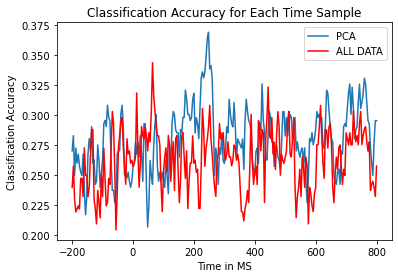

In [254]:
plt.plot(times, cv_score_array_pca)
plt.plot(times, all_data_score, color = 'red')
plt.title("Classification Accuracy for Each Time Sample")
plt.xlabel("Time in MS")
plt.ylabel("Classification Accuracy")
plt.legend(['PCA', 'ALL DATA']) 


iii. Describe the differences between the two analyses - focus on the time interval between 0 ms and 400 ms - describe in your own words why the logistic regression performs better on the PCA-reduced dataset around the peak magnetic activity  

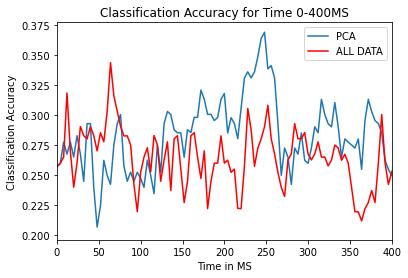

In [256]:
plt.plot(times, cv_score_array_pca)
plt.plot(times, all_data_score, color = 'red')
plt.xlim((0, 400))
plt.title("Classification Accuracy for Time 0-400MS")
plt.xlabel("Time in MS")
plt.ylabel("Classification Accuracy")
plt.legend(['PCA', 'ALL DATA']) 

*The plot shows the average of all the accuracy scores of all times classified by either PCA or the regression on all data. We see a peak in the accuracy of the PCA around 250 and a general tendency of it performing better when classifying. This makes sense explained by the sensors must have a very high activety in this. The higher the sensor activation the higher the covariance, which leads to the better performance of the PCA. When the covariane isn't that high, the difference of the classifiers aren't that big, because the new fitted PCA's doesn't provide any new information.*

